In [69]:
import pandas as pd 

fleet = ['VQ-BGU', 'VQ-BDU']

bgu = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']).dropna(subset=['egtm']) #.query('reportts <= \'2020-01-01\'')
bdu = pd.read_csv('./takeoff-merged-VQ-BDU-30s.csv', parse_dates=['reportts']).dropna(subset=['egtm']) #.query('reportts <= \'2020-01-01\'')

bgu.loc[bgu['oat'].isna(), ['oat']] = bgu.loc[bgu['oat'].isna(), :]['tat']
bdu.loc[bdu['oat'].isna(), ['oat']] = bdu.loc[bdu['oat'].isna(), :]['tat']

In [70]:
import pandas as pd
from utils import *
from training import *

y_cols = ['egtm']
meta_cols = ['reportts', 'acnum', 'pos']
features = ['egt', 'tat', 'oat', 'n1a', 'n2a', 'wai', 'nai', 'prv', 'alt', 'mn', 'ff', 'nf']


In [71]:
def correct(data):
  datak = data.copy()
  alpha = 0.5
  theta = (data['tat'] + 273.15) / 288.15
  theta_oat = (data['oat'] + 273.15) / 288.15
  delta = data['p2e'] + 1013.25

  datak['nfk'] = data['nf'] / (theta_oat ** alpha)
  datak['n1ak'] = data['n1a'] / (theta_oat ** alpha)
  datak['n1k'] = data['n1'] / (theta_oat ** alpha)
  datak['n2ak'] = data['n2a'] / (theta_oat ** alpha)
  datak['egtk'] = (data['egt'] + 273.15) / theta
  datak['ffk'] = (data['ff']) / (delta * (theta_oat ** alpha))

  return datak

In [72]:
from sklearn.linear_model import Ridge
from training import *

def predict_ensemble(models: List[Ridge], X: pd.DataFrame, field='nai'):
  pred = pd.DataFrame(index=X.index.copy(), columns=['pred'])
  for val in [True, False]:
    index = (X[field] == val)
    pred.loc[index, 'pred'] = models[val].predict(X[index])
  return pred

def filter_split_by_field(X: pd.DataFrame, y: pd.DataFrame, field: str, value: bool):
  return X[X[field] == value], y[X[field] == value]

def train_ensemble_model(X, y, model = 'linreg', field = 'nai'):
  assert len(X) == len(y)
  train_i = int(len(X) * 75 / 100)
  X_train, y_train = X[0:train_i], y[0:train_i]
  X_test, y_test = X[train_i:], y[train_i:]

  ensemble = dict()
  ensemble[True] = Ridge()
  ensemble[False] = Ridge()

  for val in [True, False]:
    X_train_f, y_train_f = filter_split_by_field(X_train, y_train, field, val)
    ensemble[val].fit(X_train_f, y_train_f)
  
  predicted_train = predict_ensemble(ensemble, X_train, field)

  predicted_test = predict_ensemble(ensemble, X_test, field)

  return get_metrics(y_test, predicted_test), model, predicted_train, predicted_test, train_i, y_test

**Обучить модель с лучшими корректирующими парамерами из прошлого эксперимента на ансамбле по NAI**

In [73]:
features_k = ['egtk', 'tat', 'n1a', 'n2a', 'wai', 'nai', 'prv', 'alt', 'mn', 'ffk', 'nf']

data = build_dataset(
  [correct(bgu), correct(bdu)], 
  y_cols, 
  meta_cols, 
  features_k,
  n_back=20,
)

X = data.drop(columns=(meta_cols + y_cols))
y = data['egtm']

metrics, model, predicted_train, predicted_test, train_i, y_test = train_ensemble_model(X, y)

print(f'NAI ensemble: {metrics}')


NAI ensemble: {'rmse': 1.69646, 'mae': 1.31405, 'r2': 0.48453, 'mape': 0.0644}


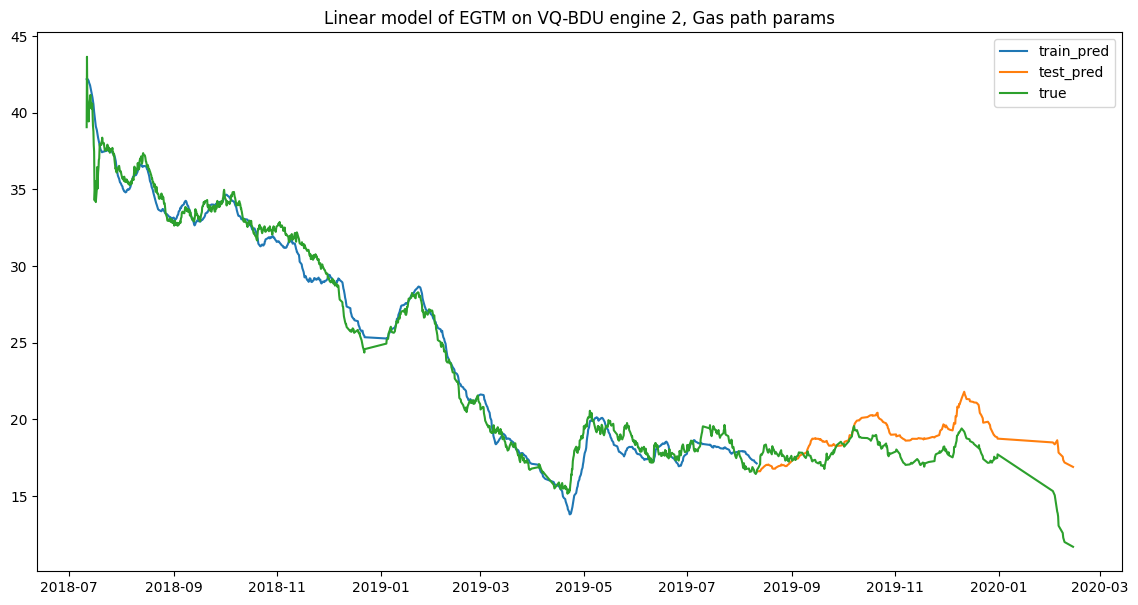

In [74]:
plot_predictions(data, 'VQ-BDU', 2, train_i, predicted_test['pred'], predicted_train['pred'], is_smooth=True)